In [1]:
# import all packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from pathlib import Path
ROOT_NOTEBOOK = Path.cwd()
PATH_UTILS = ROOT_NOTEBOOK / 'utils'
PATH_COCOAPI = ROOT_NOTEBOOK / 'dataset/cocoapi'

from datetime import datetime
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S') # obtain the running time stamp

from utilities import helpers 
from utilities import COCOKeypoint
from utilities.engine import train_one_epoch, evaluate

import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import keypointrcnn_resnet50_fpn
from torchvision.models.detection import KeypointRCNN_ResNet50_FPN_Weights as Weights

In [2]:
from torch.utils.tensorboard import SummaryWriter
tb_writer = SummaryWriter('./results/keypointrcnn_train_logs_{}'.format(timestamp))
print(f'Path of the log file: ./results/keypointrcnn_train_logs_{timestamp}')

Path of the log file: ./results/keypointrcnn_train_logs_20240916_191205


In [3]:
# print directory information
pd.Series(
    {
        'ROOT of NOTEBOOK' : ROOT_NOTEBOOK, # folder of the notebook
        'PATH of UTILITY PACKAGE' : PATH_UTILS,  # folder of the utility function
        'PATH of COCOAPI' : PATH_COCOAPI, # folder of the cocoapi
    }
).to_frame().style.hide(axis = 'columns').set_properties(**{'text-align' : 'left'})

ROOT of NOTEBOOK,/home/xzh/dev/DL/human_pose_estimation
PATH of UTILITY PACKAGE,/home/xzh/dev/DL/human_pose_estimation/utils
PATH of COCOAPI,/home/xzh/dev/DL/human_pose_estimation/dataset/cocoapi


In [4]:
# root of the COCO dataset
ROOT = Path().cwd() / "dataset/coco2017"

# directory of the train set
TRAIN_IMAGES_PATH = str(ROOT / "train2017")
# directory of the annotation (.json) file for train set
TRAIN_ANNOTATIONS_PATH = str(ROOT / "annotations/person_keypoints_train2017.json")

# directory of the validation set
VAL_IMAGES_PATH = str(ROOT / "val2017")
# directory of the annotation (.json) file for the validation set
VAL_ANNOTATIONS_PATH = str(ROOT / "annotations/person_keypoints_val2017.json")

# print info
pd.Series(
    {
        'ROOT' : ROOT,
        'TRAIN_IMAGES_PATH' : TRAIN_IMAGES_PATH,
        'TRAIN_ANNOTATIONS_PATH' : TRAIN_ANNOTATIONS_PATH,
        'VAL_IMAGES_PATH' : VAL_IMAGES_PATH,
        'VAL_ANNOTATIONS_PATH' : VAL_ANNOTATIONS_PATH
    }
).to_frame().style.hide(axis = 'columns').set_properties(**{'text-align' : 'left'})

ROOT,/home/xzh/dev/DL/human_pose_estimation/dataset/coco2017
TRAIN_IMAGES_PATH,/home/xzh/dev/DL/human_pose_estimation/dataset/coco2017/train2017
TRAIN_ANNOTATIONS_PATH,/home/xzh/dev/DL/human_pose_estimation/dataset/coco2017/annotations/person_keypoints_train2017.json
VAL_IMAGES_PATH,/home/xzh/dev/DL/human_pose_estimation/dataset/coco2017/val2017
VAL_ANNOTATIONS_PATH,/home/xzh/dev/DL/human_pose_estimation/dataset/coco2017/annotations/person_keypoints_val2017.json


In [5]:
train_dataset = COCOKeypoint.COCOKeypoint(
                                TRAIN_IMAGES_PATH, # path of train images
                                TRAIN_ANNOTATIONS_PATH, # path of annotation file
                                is_cropped=False, # whether crop images
                                crop_size=512, # crop size 
                                is_grayscale=False # whether convert to grayscale
)

val_dataset = COCOKeypoint.COCOKeypoint(
                                VAL_IMAGES_PATH, # path of train images
                                VAL_ANNOTATIONS_PATH, # path of annotation file
                                is_cropped=False, # whether crop images
                                crop_size=512, # crop size 
                                is_grayscale=False # whether convert to grayscale
)

loading annotations into memory...
Done (t=3.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [6]:
# val_sample_index = np.random.randint(0, len(val_dataset))
# val_sample_image, val_sample_annotations = val_dataset[val_sample_index]

# if (val_sample_image is not None) and (val_sample_annotations is not None):
#     # if both train_sample_image and train_sample_annotations are effective
#     # annotate sample image with keypoints
#     val_sample_images_with_keypoints = helpers.draw_keypoints(val_sample_annotations, val_sample_image)

#     # show the result
#     plt.figure()
#     plt.imshow(val_sample_images_with_keypoints, cmap='gray')
#     plt.axis('off')
#     plt.show()
    
# else:
#     # if data is not efective
#     # print the info
#     print(f'Non-effective data for {val_sample_index}-th sample')

In [7]:
train_dataloader = DataLoader(
                        dataset     =  train_dataset, 
                        batch_size  =  1, 
                        collate_fn  =  helpers.collate_fn
)
val_dataloader = DataLoader(
                        dataset     =  val_dataset, 
                        batch_size  =  1, 
                        collate_fn  =  helpers.collate_fn)

In [8]:
# pretrained model
# model = keypointrcnn_resnet50_fpn(
#                         weights       = Weights.DEFAULT,
#                         num_keypoints = 17
# )

# training model from scratch
# model = keypointrcnn_resnet50_fpn(
#                         weights       = None, 
#                         num_keypoints = 17
# )

# training model from checkpoint
model = keypointrcnn_resnet50_fpn(
                        weights       = None, 
                        num_keypoints = 17
)
model.load_state_dict(
    torch.load(
        './results/keypointrcnn_train_logs_20240916_094435/model_9.pth',
        weights_only=True
    )
)

<All keys matched successfully>

In [9]:
# empty cache memory in gpu
torch.cuda.empty_cache()

# which gpu
gpu_id = 1
device = torch.device('cuda:{}'.format(gpu_id) if torch.cuda.is_available() else 'cpu')

In [10]:
# number of epoches
epochs = 20
# starting epoch
start_epoch = 0
# epoch_index with best validation performance
best_epoch = 0
# best validation loss
best_vloss = 1_000_000
# freq of printing info
print_freq = 1000

# move model to specified device
model.to(device)

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, 

In [11]:
# define optimizer

optimizer_name = 'SGD'

learning_rate = 0.001 # learning rate
weight_decay = 1e-4 # L2 loss penalty
momentum = 0.9 # momentum for SGD

# optimizers specified in the torch.optim package
if optimizer_name in ['SGD', 'sgd', 'Stochastic Gradient Descent']:
    optimizer = torch.optim.SGD(
                        params       =    model.parameters(), 
                        lr           =    learning_rate, 
                        momentum     =    momentum, 
                        weight_decay =    weight_decay
    )
elif optimizer_name in ['AdamW', 'adamw']:
    optimizer = torch.optim.AdamW(
                        params       =    model.parameters(), 
                        lr           =    learning_rate, 
                        weight_decay =    weight_decay
    )

In [12]:
# define learning_rate scheduler

scheduler_name = 'multisteplr'

milestones = [16, 22] # when epoch_index is in milestones, adjust learning rate
gamma = 0.1 # adjust factor (x)

# optimizers specified in the torch.optim package
if scheduler_name in ['multisteplr']:
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
                        optimizer    =    optimizer,
                        milestones   =    milestones,
                        gamma        =    gamma
    )
elif scheduler_name in ['cosineannealinglr']:
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
                        optimizer    =    optimizer,
                        T_max        =    epochs
    )
else:
    lr_scheduler = None

In [13]:
# define scaler for auto mixed precision

scaler = torch.GradScaler(device)

In [14]:
# train begins
for epoch_index in tqdm(range(start_epoch, epochs)):
    
    avg_tloss, _ = train_one_epoch(
                        model          =   model, 
                        optimizer      =   optimizer,  
                        data_loader    =   train_dataloader, 
                        device         =   device, 
                        epoch          =   epoch_index, 
                        print_freq     =   print_freq, 
                        scaler         =   scaler,
                        tb_writer      =   tb_writer
    )

    # adjust learning rate
    lr_scheduler.step()

    # eavluate the trained model
    avg_vloss, _ = evaluate(
                        model          =   model, 
                        data_loader    =   val_dataloader, 
                        device         =   device,
                        print_freq     =   100
    )

    # write loss_info
    tb_writer.add_scalars(
        'Training vs. Validation Loss', 
        {
            'Training': avg_tloss, 
            'Validation': avg_vloss
        }, 
        epoch_index+1
    )

    tb_writer.flush()
    
    # if average batch val loss decreases
    # save model
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        best_epoch = epoch_index
        model_path = './results/keypointrcnn_train_logs_{}/model_{}.pth'.format(timestamp, best_epoch)
        torch.save(model.state_dict(), model_path)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [0]  [    0/64115]  eta: 11:23:49  loss_value: 2.7135 (2.7135)  lr: 0.0010 (0.0010)  time: 0.6399  data: 0.0079  max mem: 0
Epoch: [0]  [ 1000/64115]  eta: 1:45:02  loss_value: 3.6673 (3.6012)  lr: 0.0010 (0.0010)  time: 0.1006  data: 0.0057  max mem: 0
Epoch: [0]  [ 2000/64115]  eta: 1:40:35  loss_value: 4.0541 (3.6372)  lr: 0.0010 (0.0010)  time: 0.0946  data: 0.0054  max mem: 0
Epoch: [0]  [ 3000/64115]  eta: 1:37:57  loss_value: 3.5985 (3.6415)  lr: 0.0010 (0.0010)  time: 0.1012  data: 0.0055  max mem: 0
Epoch: [0]  [ 4000/64115]  eta: 1:35:28  loss_value: 3.9117 (3.6214)  lr: 0.0010 (0.0010)  time: 0.0987  data: 0.0057  max mem: 0
Epoch: [0]  [ 5000/64115]  eta: 1:33:48  loss_value: 4.3477 (3.6216)  lr: 0.0010 (0.0010)  time: 0.1012  data: 0.0056  max mem: 0
Epoch: [0]  [ 6000/64115]  eta: 1:32:00  loss_value: 3.7600 (3.6126)  lr: 0.0010 (0.0010)  time: 0.1011  data: 0.0055  max mem: 0
Epoch: [0]  [ 7000/64115]  eta: 1:30:08  loss_value: 3.4255 (3.5949)  lr: 0.0010 (0.0010)

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:02:08  loss_value: 3.9300 (3.9300)  model_time: 0.0427 (0.0427)  time: 0.0477  data: 0.0046  max mem: 0
Test:  [ 100/2693]  eta: 0:01:22  loss_value: 3.8917 (4.0508)  model_time: 0.0196 (0.0265)  time: 0.0286  data: 0.0050  max mem: 0
Test:  [ 200/2693]  eta: 0:01:12  loss_value: 4.0324 (3.8921)  model_time: 0.0193 (0.0238)  time: 0.0271  data: 0.0043  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.0842 (3.8109)  model_time: 0.0254 (0.0233)  time: 0.0287  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:04  loss_value: 4.1682 (3.8683)  model_time: 0.0189 (0.0230)  time: 0.0270  data: 0.0049  max mem: 0
Test:  [ 500/2693]  eta: 0:01:00  loss_value: 3.6645 (3.8294)  model_time: 0.0169 (0.0225)  time: 0.0243  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.9243 (3.8413)  model_time: 0.0183 (0.0221)  time: 0.0264  data: 0.0047  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.4960 (3.8242)  model_time: 0.0228 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [1]  [    0/64115]  eta: 1:01:34  loss_value: 3.0038 (3.0038)  lr: 0.0010 (0.0010)  time: 0.0576  data: 0.0060  max mem: 0
Epoch: [1]  [ 1000/64115]  eta: 0:46:12  loss_value: 3.6031 (3.5644)  lr: 0.0010 (0.0010)  time: 0.0425  data: 0.0052  max mem: 0
Epoch: [1]  [ 2000/64115]  eta: 0:44:19  loss_value: 3.9718 (3.6032)  lr: 0.0010 (0.0010)  time: 0.0397  data: 0.0052  max mem: 0
Epoch: [1]  [ 3000/64115]  eta: 0:43:11  loss_value: 3.6506 (3.6064)  lr: 0.0010 (0.0010)  time: 0.0440  data: 0.0051  max mem: 0
Epoch: [1]  [ 4000/64115]  eta: 0:42:04  loss_value: 3.6649 (3.5828)  lr: 0.0010 (0.0010)  time: 0.0419  data: 0.0049  max mem: 0
Epoch: [1]  [ 5000/64115]  eta: 0:41:17  loss_value: 4.5107 (3.5844)  lr: 0.0010 (0.0010)  time: 0.0450  data: 0.0049  max mem: 0
Epoch: [1]  [ 6000/64115]  eta: 0:40:28  loss_value: 3.8636 (3.5755)  lr: 0.0010 (0.0010)  time: 0.0443  data: 0.0052  max mem: 0
Epoch: [1]  [ 7000/64115]  eta: 0:39:40  loss_value: 3.6194 (3.5610)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:37  loss_value: 4.3099 (4.3099)  model_time: 0.0309 (0.0309)  time: 0.0363  data: 0.0049  max mem: 0
Test:  [ 100/2693]  eta: 0:01:23  loss_value: 3.5127 (4.1048)  model_time: 0.0250 (0.0268)  time: 0.0307  data: 0.0051  max mem: 0
Test:  [ 200/2693]  eta: 0:01:13  loss_value: 3.9706 (3.9784)  model_time: 0.0210 (0.0240)  time: 0.0277  data: 0.0044  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.2469 (3.9247)  model_time: 0.0204 (0.0235)  time: 0.0299  data: 0.0046  max mem: 0
Test:  [ 400/2693]  eta: 0:01:04  loss_value: 4.1609 (3.9787)  model_time: 0.0189 (0.0230)  time: 0.0263  data: 0.0050  max mem: 0
Test:  [ 500/2693]  eta: 0:01:00  loss_value: 3.6657 (3.9255)  model_time: 0.0182 (0.0225)  time: 0.0256  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 4.1103 (3.9469)  model_time: 0.0181 (0.0221)  time: 0.0258  data: 0.0047  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.6098 (3.9449)  model_time: 0.0214 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [2]  [    0/64115]  eta: 0:39:24  loss_value: 2.7550 (2.7550)  lr: 0.0010 (0.0010)  time: 0.0369  data: 0.0056  max mem: 0
Epoch: [2]  [ 1000/64115]  eta: 0:46:05  loss_value: 3.4384 (3.6008)  lr: 0.0010 (0.0010)  time: 0.0427  data: 0.0052  max mem: 0
Epoch: [2]  [ 2000/64115]  eta: 0:44:10  loss_value: 3.8600 (3.6296)  lr: 0.0010 (0.0010)  time: 0.0397  data: 0.0053  max mem: 0
Epoch: [2]  [ 3000/64115]  eta: 0:43:03  loss_value: 3.7789 (3.6121)  lr: 0.0010 (0.0010)  time: 0.0445  data: 0.0050  max mem: 0
Epoch: [2]  [ 4000/64115]  eta: 0:41:58  loss_value: 3.5805 (3.5788)  lr: 0.0010 (0.0010)  time: 0.0419  data: 0.0049  max mem: 0
Epoch: [2]  [ 5000/64115]  eta: 0:41:07  loss_value: 4.3535 (3.5758)  lr: 0.0010 (0.0010)  time: 0.0446  data: 0.0049  max mem: 0
Epoch: [2]  [ 6000/64115]  eta: 0:40:18  loss_value: 3.7877 (3.5683)  lr: 0.0010 (0.0010)  time: 0.0438  data: 0.0052  max mem: 0
Epoch: [2]  [ 7000/64115]  eta: 0:39:30  loss_value: 3.5712 (3.5517)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:35  loss_value: 4.4563 (4.4563)  model_time: 0.0305 (0.0305)  time: 0.0356  data: 0.0046  max mem: 0
Test:  [ 100/2693]  eta: 0:01:22  loss_value: 3.6950 (4.0915)  model_time: 0.0243 (0.0263)  time: 0.0290  data: 0.0052  max mem: 0
Test:  [ 200/2693]  eta: 0:01:13  loss_value: 4.0735 (3.9124)  model_time: 0.0194 (0.0242)  time: 0.0267  data: 0.0044  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.4105 (3.8347)  model_time: 0.0252 (0.0235)  time: 0.0298  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:04  loss_value: 4.0676 (3.8820)  model_time: 0.0194 (0.0229)  time: 0.0255  data: 0.0048  max mem: 0
Test:  [ 500/2693]  eta: 0:01:00  loss_value: 3.5416 (3.8187)  model_time: 0.0170 (0.0225)  time: 0.0245  data: 0.0045  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.8109 (3.8232)  model_time: 0.0183 (0.0221)  time: 0.0258  data: 0.0043  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.4938 (3.8122)  model_time: 0.0198 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [3]  [    0/64115]  eta: 1:01:53  loss_value: 2.7637 (2.7637)  lr: 0.0010 (0.0010)  time: 0.0579  data: 0.0059  max mem: 0
Epoch: [3]  [ 1000/64115]  eta: 0:46:26  loss_value: 3.2100 (3.5247)  lr: 0.0010 (0.0010)  time: 0.0449  data: 0.0051  max mem: 0
Epoch: [3]  [ 2000/64115]  eta: 0:44:16  loss_value: 3.9116 (3.5540)  lr: 0.0010 (0.0010)  time: 0.0406  data: 0.0051  max mem: 0
Epoch: [3]  [ 3000/64115]  eta: 0:43:15  loss_value: 3.7003 (3.5590)  lr: 0.0010 (0.0010)  time: 0.0429  data: 0.0050  max mem: 0
Epoch: [3]  [ 4000/64115]  eta: 0:42:08  loss_value: 3.5804 (3.5290)  lr: 0.0010 (0.0010)  time: 0.0418  data: 0.0049  max mem: 0
Epoch: [3]  [ 5000/64115]  eta: 0:41:18  loss_value: 4.2893 (3.5329)  lr: 0.0010 (0.0010)  time: 0.0443  data: 0.0047  max mem: 0
Epoch: [3]  [ 6000/64115]  eta: 0:40:26  loss_value: 3.9790 (3.5290)  lr: 0.0010 (0.0010)  time: 0.0450  data: 0.0051  max mem: 0
Epoch: [3]  [ 7000/64115]  eta: 0:39:37  loss_value: 3.4355 (3.5149)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:35  loss_value: 3.9490 (3.9490)  model_time: 0.0308 (0.0308)  time: 0.0356  data: 0.0044  max mem: 0
Test:  [ 100/2693]  eta: 0:01:22  loss_value: 3.7260 (4.0268)  model_time: 0.0198 (0.0263)  time: 0.0275  data: 0.0049  max mem: 0
Test:  [ 200/2693]  eta: 0:01:12  loss_value: 3.8472 (3.8906)  model_time: 0.0211 (0.0237)  time: 0.0267  data: 0.0044  max mem: 0
Test:  [ 300/2693]  eta: 0:01:07  loss_value: 4.1259 (3.8161)  model_time: 0.0246 (0.0232)  time: 0.0289  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:04  loss_value: 3.9302 (3.8712)  model_time: 0.0179 (0.0229)  time: 0.0263  data: 0.0049  max mem: 0
Test:  [ 500/2693]  eta: 0:01:00  loss_value: 3.7010 (3.8204)  model_time: 0.0171 (0.0224)  time: 0.0248  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.5890 (3.8196)  model_time: 0.0186 (0.0221)  time: 0.0253  data: 0.0046  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.4944 (3.8092)  model_time: 0.0222 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [4]  [    0/64115]  eta: 0:59:29  loss_value: 3.0980 (3.0980)  lr: 0.0010 (0.0010)  time: 0.0557  data: 0.0060  max mem: 0
Epoch: [4]  [ 1000/64115]  eta: 0:46:27  loss_value: 3.2523 (3.4893)  lr: 0.0010 (0.0010)  time: 0.0428  data: 0.0051  max mem: 0
Epoch: [4]  [ 2000/64115]  eta: 0:44:16  loss_value: 3.8833 (3.5294)  lr: 0.0010 (0.0010)  time: 0.0427  data: 0.0053  max mem: 0
Epoch: [4]  [ 3000/64115]  eta: 0:43:14  loss_value: 3.5158 (3.5233)  lr: 0.0010 (0.0010)  time: 0.0427  data: 0.0051  max mem: 0
Epoch: [4]  [ 4000/64115]  eta: 0:42:08  loss_value: 3.5695 (3.5014)  lr: 0.0010 (0.0010)  time: 0.0414  data: 0.0049  max mem: 0
Epoch: [4]  [ 5000/64115]  eta: 0:41:17  loss_value: 4.5114 (3.5021)  lr: 0.0010 (0.0010)  time: 0.0446  data: 0.0047  max mem: 0
Epoch: [4]  [ 6000/64115]  eta: 0:40:25  loss_value: 3.8652 (3.4912)  lr: 0.0010 (0.0010)  time: 0.0436  data: 0.0050  max mem: 0
Epoch: [4]  [ 7000/64115]  eta: 0:39:36  loss_value: 3.5995 (3.4786)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:36  loss_value: 4.3226 (4.3226)  model_time: 0.0310 (0.0310)  time: 0.0360  data: 0.0045  max mem: 0
Test:  [ 100/2693]  eta: 0:01:23  loss_value: 4.0765 (4.0500)  model_time: 0.0230 (0.0268)  time: 0.0278  data: 0.0051  max mem: 0
Test:  [ 200/2693]  eta: 0:01:14  loss_value: 4.0239 (3.9314)  model_time: 0.0202 (0.0245)  time: 0.0267  data: 0.0046  max mem: 0
Test:  [ 300/2693]  eta: 0:01:09  loss_value: 4.1363 (3.8579)  model_time: 0.0247 (0.0237)  time: 0.0296  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 4.0862 (3.9050)  model_time: 0.0177 (0.0232)  time: 0.0250  data: 0.0047  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.5774 (3.8441)  model_time: 0.0172 (0.0227)  time: 0.0249  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.4097 (3.8535)  model_time: 0.0185 (0.0224)  time: 0.0261  data: 0.0046  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.5352 (3.8395)  model_time: 0.0213 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [5]  [    0/64115]  eta: 0:59:32  loss_value: 2.9225 (2.9225)  lr: 0.0010 (0.0010)  time: 0.0557  data: 0.0060  max mem: 0
Epoch: [5]  [ 1000/64115]  eta: 0:46:09  loss_value: 3.1230 (3.4589)  lr: 0.0010 (0.0010)  time: 0.0434  data: 0.0052  max mem: 0
Epoch: [5]  [ 2000/64115]  eta: 0:44:05  loss_value: 3.6802 (3.4968)  lr: 0.0010 (0.0010)  time: 0.0392  data: 0.0051  max mem: 0
Epoch: [5]  [ 3000/64115]  eta: 0:43:05  loss_value: 3.4975 (3.5016)  lr: 0.0010 (0.0010)  time: 0.0438  data: 0.0052  max mem: 0
Epoch: [5]  [ 4000/64115]  eta: 0:42:01  loss_value: 3.4747 (3.4751)  lr: 0.0010 (0.0010)  time: 0.0407  data: 0.0050  max mem: 0
Epoch: [5]  [ 5000/64115]  eta: 0:41:12  loss_value: 4.2500 (3.4709)  lr: 0.0010 (0.0010)  time: 0.0454  data: 0.0047  max mem: 0
Epoch: [5]  [ 6000/64115]  eta: 0:40:22  loss_value: 3.7749 (3.4617)  lr: 0.0010 (0.0010)  time: 0.0440  data: 0.0049  max mem: 0
Epoch: [5]  [ 7000/64115]  eta: 0:39:34  loss_value: 3.3364 (3.4465)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:40  loss_value: 4.2702 (4.2702)  model_time: 0.0324 (0.0324)  time: 0.0375  data: 0.0047  max mem: 0
Test:  [ 100/2693]  eta: 0:01:23  loss_value: 3.7105 (4.1133)  model_time: 0.0206 (0.0268)  time: 0.0289  data: 0.0050  max mem: 0
Test:  [ 200/2693]  eta: 0:01:13  loss_value: 3.8473 (3.9371)  model_time: 0.0213 (0.0243)  time: 0.0279  data: 0.0045  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.5507 (3.8497)  model_time: 0.0225 (0.0235)  time: 0.0286  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 3.9162 (3.9035)  model_time: 0.0189 (0.0232)  time: 0.0263  data: 0.0049  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.4167 (3.8539)  model_time: 0.0191 (0.0228)  time: 0.0264  data: 0.0048  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.4979 (3.8625)  model_time: 0.0178 (0.0224)  time: 0.0255  data: 0.0046  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.7595 (3.8529)  model_time: 0.0217 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [6]  [    0/64115]  eta: 0:34:34  loss_value: 2.8483 (2.8483)  lr: 0.0010 (0.0010)  time: 0.0324  data: 0.0060  max mem: 0
Epoch: [6]  [ 1000/64115]  eta: 0:46:23  loss_value: 3.0597 (3.4382)  lr: 0.0010 (0.0010)  time: 0.0421  data: 0.0050  max mem: 0
Epoch: [6]  [ 2000/64115]  eta: 0:44:19  loss_value: 3.5362 (3.4688)  lr: 0.0010 (0.0010)  time: 0.0420  data: 0.0051  max mem: 0
Epoch: [6]  [ 3000/64115]  eta: 0:43:12  loss_value: 3.3634 (3.4525)  lr: 0.0010 (0.0010)  time: 0.0434  data: 0.0050  max mem: 0
Epoch: [6]  [ 4000/64115]  eta: 0:42:08  loss_value: 3.6997 (3.4384)  lr: 0.0010 (0.0010)  time: 0.0413  data: 0.0049  max mem: 0
Epoch: [6]  [ 5000/64115]  eta: 0:41:20  loss_value: 4.1125 (3.4355)  lr: 0.0010 (0.0010)  time: 0.0445  data: 0.0049  max mem: 0
Epoch: [6]  [ 6000/64115]  eta: 0:40:29  loss_value: 3.3270 (3.4269)  lr: 0.0010 (0.0010)  time: 0.0438  data: 0.0051  max mem: 0
Epoch: [6]  [ 7000/64115]  eta: 0:39:40  loss_value: 3.3469 (3.4065)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:36  loss_value: 4.7081 (4.7081)  model_time: 0.0307 (0.0307)  time: 0.0359  data: 0.0048  max mem: 0
Test:  [ 100/2693]  eta: 0:01:24  loss_value: 3.8370 (3.9917)  model_time: 0.0196 (0.0273)  time: 0.0281  data: 0.0049  max mem: 0
Test:  [ 200/2693]  eta: 0:01:14  loss_value: 3.9409 (3.8666)  model_time: 0.0239 (0.0247)  time: 0.0283  data: 0.0045  max mem: 0
Test:  [ 300/2693]  eta: 0:01:10  loss_value: 4.2713 (3.8120)  model_time: 0.0255 (0.0241)  time: 0.0298  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:06  loss_value: 4.0307 (3.8731)  model_time: 0.0181 (0.0237)  time: 0.0262  data: 0.0049  max mem: 0
Test:  [ 500/2693]  eta: 0:01:02  loss_value: 3.6610 (3.8264)  model_time: 0.0182 (0.0230)  time: 0.0252  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:58  loss_value: 3.8239 (3.8423)  model_time: 0.0187 (0.0227)  time: 0.0260  data: 0.0047  max mem: 0
Test:  [ 700/2693]  eta: 0:00:55  loss_value: 4.5522 (3.8306)  model_time: 0.0213 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [7]  [    0/64115]  eta: 0:57:29  loss_value: 2.5695 (2.5695)  lr: 0.0010 (0.0010)  time: 0.0538  data: 0.0062  max mem: 0
Epoch: [7]  [ 1000/64115]  eta: 0:46:14  loss_value: 3.3679 (3.4189)  lr: 0.0010 (0.0010)  time: 0.0415  data: 0.0052  max mem: 0
Epoch: [7]  [ 2000/64115]  eta: 0:44:19  loss_value: 3.8332 (3.4742)  lr: 0.0010 (0.0010)  time: 0.0389  data: 0.0052  max mem: 0
Epoch: [7]  [ 3000/64115]  eta: 0:43:11  loss_value: 3.4186 (3.4671)  lr: 0.0010 (0.0010)  time: 0.0432  data: 0.0052  max mem: 0
Epoch: [7]  [ 4000/64115]  eta: 0:42:05  loss_value: 3.5053 (3.4454)  lr: 0.0010 (0.0010)  time: 0.0408  data: 0.0049  max mem: 0
Epoch: [7]  [ 5000/64115]  eta: 0:41:14  loss_value: 4.2292 (3.4418)  lr: 0.0010 (0.0010)  time: 0.0445  data: 0.0049  max mem: 0
Epoch: [7]  [ 6000/64115]  eta: 0:40:26  loss_value: 3.8397 (3.4304)  lr: 0.0010 (0.0010)  time: 0.0435  data: 0.0052  max mem: 0
Epoch: [7]  [ 7000/64115]  eta: 0:39:38  loss_value: 3.3176 (3.4186)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:35  loss_value: 4.5168 (4.5168)  model_time: 0.0305 (0.0305)  time: 0.0355  data: 0.0046  max mem: 0
Test:  [ 100/2693]  eta: 0:01:22  loss_value: 3.4688 (4.0301)  model_time: 0.0217 (0.0266)  time: 0.0291  data: 0.0050  max mem: 0
Test:  [ 200/2693]  eta: 0:01:13  loss_value: 3.8475 (3.9005)  model_time: 0.0217 (0.0242)  time: 0.0278  data: 0.0045  max mem: 0
Test:  [ 300/2693]  eta: 0:01:09  loss_value: 4.2017 (3.8363)  model_time: 0.0257 (0.0237)  time: 0.0301  data: 0.0045  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 4.3004 (3.8949)  model_time: 0.0183 (0.0231)  time: 0.0250  data: 0.0048  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.7051 (3.8460)  model_time: 0.0171 (0.0226)  time: 0.0245  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.8060 (3.8479)  model_time: 0.0193 (0.0223)  time: 0.0268  data: 0.0046  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.7102 (3.8378)  model_time: 0.0212 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [8]  [    0/64115]  eta: 0:59:26  loss_value: 2.7093 (2.7093)  lr: 0.0010 (0.0010)  time: 0.0556  data: 0.0056  max mem: 0
Epoch: [8]  [ 1000/64115]  eta: 0:46:24  loss_value: 3.2595 (3.4224)  lr: 0.0010 (0.0010)  time: 0.0427  data: 0.0051  max mem: 0
Epoch: [8]  [ 2000/64115]  eta: 0:44:23  loss_value: 3.7469 (3.4363)  lr: 0.0010 (0.0010)  time: 0.0391  data: 0.0051  max mem: 0
Epoch: [8]  [ 3000/64115]  eta: 0:43:21  loss_value: 3.1431 (3.4205)  lr: 0.0010 (0.0010)  time: 0.0429  data: 0.0051  max mem: 0
Epoch: [8]  [ 4000/64115]  eta: 0:42:12  loss_value: 3.6254 (3.4006)  lr: 0.0010 (0.0010)  time: 0.0417  data: 0.0048  max mem: 0
Epoch: [8]  [ 5000/64115]  eta: 0:41:21  loss_value: 4.1039 (3.4153)  lr: 0.0010 (0.0010)  time: 0.0456  data: 0.0049  max mem: 0
Epoch: [8]  [ 6000/64115]  eta: 0:40:31  loss_value: 3.8949 (3.4104)  lr: 0.0010 (0.0010)  time: 0.0431  data: 0.0050  max mem: 0
Epoch: [8]  [ 7000/64115]  eta: 0:39:42  loss_value: 3.4345 (3.3929)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:37  loss_value: 3.9220 (3.9220)  model_time: 0.0311 (0.0311)  time: 0.0361  data: 0.0046  max mem: 0
Test:  [ 100/2693]  eta: 0:01:24  loss_value: 3.6227 (4.0027)  model_time: 0.0236 (0.0270)  time: 0.0301  data: 0.0051  max mem: 0
Test:  [ 200/2693]  eta: 0:01:13  loss_value: 3.5756 (3.8738)  model_time: 0.0213 (0.0243)  time: 0.0271  data: 0.0045  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.3656 (3.8228)  model_time: 0.0244 (0.0234)  time: 0.0284  data: 0.0044  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 3.9214 (3.8650)  model_time: 0.0202 (0.0232)  time: 0.0269  data: 0.0048  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.6709 (3.8085)  model_time: 0.0188 (0.0227)  time: 0.0257  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.6516 (3.8259)  model_time: 0.0191 (0.0223)  time: 0.0261  data: 0.0046  max mem: 0
Test:  [ 700/2693]  eta: 0:00:55  loss_value: 4.6874 (3.8169)  model_time: 0.0254 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [9]  [    0/64115]  eta: 0:34:17  loss_value: 2.7639 (2.7639)  lr: 0.0010 (0.0010)  time: 0.0321  data: 0.0055  max mem: 0
Epoch: [9]  [ 1000/64115]  eta: 0:46:29  loss_value: 3.1583 (3.3910)  lr: 0.0010 (0.0010)  time: 0.0412  data: 0.0052  max mem: 0
Epoch: [9]  [ 2000/64115]  eta: 0:44:36  loss_value: 3.8773 (3.4027)  lr: 0.0010 (0.0010)  time: 0.0395  data: 0.0051  max mem: 0
Epoch: [9]  [ 3000/64115]  eta: 0:43:26  loss_value: 3.5202 (3.3978)  lr: 0.0010 (0.0010)  time: 0.0433  data: 0.0053  max mem: 0
Epoch: [9]  [ 4000/64115]  eta: 0:42:17  loss_value: 3.5598 (3.3764)  lr: 0.0010 (0.0010)  time: 0.0420  data: 0.0049  max mem: 0
Epoch: [9]  [ 5000/64115]  eta: 0:41:27  loss_value: 4.1413 (3.3738)  lr: 0.0010 (0.0010)  time: 0.0448  data: 0.0048  max mem: 0
Epoch: [9]  [ 6000/64115]  eta: 0:40:35  loss_value: 3.4247 (3.3628)  lr: 0.0010 (0.0010)  time: 0.0468  data: 0.0052  max mem: 0
Epoch: [9]  [ 7000/64115]  eta: 0:39:45  loss_value: 3.4189 (3.3494)  lr: 0.0010 (0.0010) 

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:36  loss_value: 4.3294 (4.3294)  model_time: 0.0306 (0.0306)  time: 0.0358  data: 0.0047  max mem: 0
Test:  [ 100/2693]  eta: 0:01:20  loss_value: 3.4933 (4.0099)  model_time: 0.0187 (0.0257)  time: 0.0276  data: 0.0050  max mem: 0
Test:  [ 200/2693]  eta: 0:01:12  loss_value: 3.8459 (3.9016)  model_time: 0.0207 (0.0238)  time: 0.0275  data: 0.0047  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.3502 (3.8296)  model_time: 0.0257 (0.0233)  time: 0.0295  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:04  loss_value: 4.1424 (3.8741)  model_time: 0.0202 (0.0230)  time: 0.0270  data: 0.0047  max mem: 0
Test:  [ 500/2693]  eta: 0:01:00  loss_value: 3.8043 (3.8190)  model_time: 0.0178 (0.0225)  time: 0.0243  data: 0.0045  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.6151 (3.8242)  model_time: 0.0191 (0.0222)  time: 0.0275  data: 0.0045  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.6090 (3.8153)  model_time: 0.0230 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [10]  [    0/64115]  eta: 0:37:19  loss_value: 2.6741 (2.6741)  lr: 0.0010 (0.0010)  time: 0.0349  data: 0.0060  max mem: 0
Epoch: [10]  [ 1000/64115]  eta: 0:46:26  loss_value: 3.2987 (3.3674)  lr: 0.0010 (0.0010)  time: 0.0423  data: 0.0052  max mem: 0
Epoch: [10]  [ 2000/64115]  eta: 0:44:21  loss_value: 3.5942 (3.3889)  lr: 0.0010 (0.0010)  time: 0.0406  data: 0.0052  max mem: 0
Epoch: [10]  [ 3000/64115]  eta: 0:43:10  loss_value: 3.4756 (3.3796)  lr: 0.0010 (0.0010)  time: 0.0428  data: 0.0050  max mem: 0
Epoch: [10]  [ 4000/64115]  eta: 0:42:05  loss_value: 3.1324 (3.3539)  lr: 0.0010 (0.0010)  time: 0.0414  data: 0.0049  max mem: 0
Epoch: [10]  [ 5000/64115]  eta: 0:41:17  loss_value: 4.0608 (3.3523)  lr: 0.0010 (0.0010)  time: 0.0453  data: 0.0050  max mem: 0
Epoch: [10]  [ 6000/64115]  eta: 0:40:27  loss_value: 3.4447 (3.3480)  lr: 0.0010 (0.0010)  time: 0.0442  data: 0.0052  max mem: 0
Epoch: [10]  [ 7000/64115]  eta: 0:39:38  loss_value: 3.1549 (3.3365)  lr: 0.0010 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:36  loss_value: 4.0972 (4.0972)  model_time: 0.0308 (0.0308)  time: 0.0357  data: 0.0045  max mem: 0
Test:  [ 100/2693]  eta: 0:01:23  loss_value: 3.7797 (4.0125)  model_time: 0.0186 (0.0268)  time: 0.0274  data: 0.0048  max mem: 0
Test:  [ 200/2693]  eta: 0:01:14  loss_value: 3.9120 (3.8795)  model_time: 0.0249 (0.0245)  time: 0.0290  data: 0.0045  max mem: 0
Test:  [ 300/2693]  eta: 0:01:09  loss_value: 4.3280 (3.8204)  model_time: 0.0223 (0.0237)  time: 0.0283  data: 0.0045  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 3.8037 (3.8670)  model_time: 0.0187 (0.0234)  time: 0.0260  data: 0.0048  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.6791 (3.8146)  model_time: 0.0171 (0.0229)  time: 0.0248  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.7308 (3.8305)  model_time: 0.0186 (0.0225)  time: 0.0264  data: 0.0045  max mem: 0
Test:  [ 700/2693]  eta: 0:00:55  loss_value: 4.7293 (3.8184)  model_time: 0.0238 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [11]  [    0/64115]  eta: 1:00:00  loss_value: 2.4641 (2.4641)  lr: 0.0010 (0.0010)  time: 0.0562  data: 0.0059  max mem: 0
Epoch: [11]  [ 1000/64115]  eta: 0:46:24  loss_value: 3.2093 (3.3517)  lr: 0.0010 (0.0010)  time: 0.0426  data: 0.0053  max mem: 0
Epoch: [11]  [ 2000/64115]  eta: 0:44:31  loss_value: 3.7271 (3.3821)  lr: 0.0010 (0.0010)  time: 0.0432  data: 0.0051  max mem: 0
Epoch: [11]  [ 3000/64115]  eta: 0:43:27  loss_value: 3.3995 (3.3709)  lr: 0.0010 (0.0010)  time: 0.0441  data: 0.0051  max mem: 0
Epoch: [11]  [ 4000/64115]  eta: 0:42:21  loss_value: 3.5349 (3.3559)  lr: 0.0010 (0.0010)  time: 0.0421  data: 0.0051  max mem: 0
Epoch: [11]  [ 5000/64115]  eta: 0:41:27  loss_value: 4.0407 (3.3726)  lr: 0.0010 (0.0010)  time: 0.0451  data: 0.0047  max mem: 0
Epoch: [11]  [ 6000/64115]  eta: 0:40:36  loss_value: 3.3897 (3.3637)  lr: 0.0010 (0.0010)  time: 0.0443  data: 0.0052  max mem: 0
Epoch: [11]  [ 7000/64115]  eta: 0:39:48  loss_value: 3.2981 (3.3522)  lr: 0.0010 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:35  loss_value: 4.6019 (4.6019)  model_time: 0.0304 (0.0304)  time: 0.0353  data: 0.0045  max mem: 0
Test:  [ 100/2693]  eta: 0:01:21  loss_value: 3.6637 (4.0758)  model_time: 0.0182 (0.0263)  time: 0.0279  data: 0.0048  max mem: 0
Test:  [ 200/2693]  eta: 0:01:12  loss_value: 3.9675 (3.9372)  model_time: 0.0190 (0.0240)  time: 0.0269  data: 0.0046  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.2750 (3.8520)  model_time: 0.0265 (0.0234)  time: 0.0308  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:04  loss_value: 4.0590 (3.8908)  model_time: 0.0185 (0.0230)  time: 0.0250  data: 0.0049  max mem: 0
Test:  [ 500/2693]  eta: 0:01:00  loss_value: 3.8975 (3.8498)  model_time: 0.0181 (0.0226)  time: 0.0245  data: 0.0047  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.8703 (3.8632)  model_time: 0.0189 (0.0223)  time: 0.0266  data: 0.0047  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.6201 (3.8510)  model_time: 0.0217 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [12]  [    0/64115]  eta: 0:35:31  loss_value: 2.7890 (2.7890)  lr: 0.0010 (0.0010)  time: 0.0332  data: 0.0056  max mem: 0
Epoch: [12]  [ 1000/64115]  eta: 0:46:29  loss_value: 3.2289 (3.3433)  lr: 0.0010 (0.0010)  time: 0.0418  data: 0.0052  max mem: 0
Epoch: [12]  [ 2000/64115]  eta: 0:44:26  loss_value: 3.4597 (3.3546)  lr: 0.0010 (0.0010)  time: 0.0419  data: 0.0054  max mem: 0
Epoch: [12]  [ 3000/64115]  eta: 0:43:19  loss_value: 3.3450 (3.3506)  lr: 0.0010 (0.0010)  time: 0.0435  data: 0.0053  max mem: 0
Epoch: [12]  [ 4000/64115]  eta: 0:42:10  loss_value: 3.1579 (3.3212)  lr: 0.0010 (0.0010)  time: 0.0406  data: 0.0048  max mem: 0
Epoch: [12]  [ 5000/64115]  eta: 0:41:23  loss_value: 4.1945 (3.3220)  lr: 0.0010 (0.0010)  time: 0.0449  data: 0.0047  max mem: 0
Epoch: [12]  [ 6000/64115]  eta: 0:40:33  loss_value: 3.3786 (3.3132)  lr: 0.0010 (0.0010)  time: 0.0450  data: 0.0053  max mem: 0
Epoch: [12]  [ 7000/64115]  eta: 0:39:45  loss_value: 3.2209 (3.2985)  lr: 0.0010 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:36  loss_value: 4.2995 (4.2995)  model_time: 0.0306 (0.0306)  time: 0.0358  data: 0.0047  max mem: 0
Test:  [ 100/2693]  eta: 0:01:22  loss_value: 3.7605 (4.0929)  model_time: 0.0182 (0.0263)  time: 0.0274  data: 0.0049  max mem: 0
Test:  [ 200/2693]  eta: 0:01:13  loss_value: 3.9233 (3.9215)  model_time: 0.0204 (0.0240)  time: 0.0281  data: 0.0047  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.2444 (3.8676)  model_time: 0.0257 (0.0234)  time: 0.0287  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 4.0260 (3.9036)  model_time: 0.0196 (0.0230)  time: 0.0257  data: 0.0049  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.5652 (3.8575)  model_time: 0.0184 (0.0226)  time: 0.0251  data: 0.0047  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 4.0139 (3.8653)  model_time: 0.0193 (0.0222)  time: 0.0275  data: 0.0047  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.8322 (3.8553)  model_time: 0.0233 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [13]  [    0/64115]  eta: 0:58:10  loss_value: 2.6940 (2.6940)  lr: 0.0010 (0.0010)  time: 0.0544  data: 0.0059  max mem: 0
Epoch: [13]  [ 1000/64115]  eta: 0:46:25  loss_value: 3.2247 (3.3280)  lr: 0.0010 (0.0010)  time: 0.0448  data: 0.0051  max mem: 0
Epoch: [13]  [ 2000/64115]  eta: 0:44:22  loss_value: 3.6049 (3.3615)  lr: 0.0010 (0.0010)  time: 0.0398  data: 0.0053  max mem: 0
Epoch: [13]  [ 3000/64115]  eta: 0:43:19  loss_value: 2.8596 (3.3538)  lr: 0.0010 (0.0010)  time: 0.0448  data: 0.0051  max mem: 0
Epoch: [13]  [ 4000/64115]  eta: 0:42:13  loss_value: 3.4234 (3.3349)  lr: 0.0010 (0.0010)  time: 0.0407  data: 0.0048  max mem: 0
Epoch: [13]  [ 5000/64115]  eta: 0:41:22  loss_value: 4.0884 (3.3349)  lr: 0.0010 (0.0010)  time: 0.0444  data: 0.0048  max mem: 0
Epoch: [13]  [ 6000/64115]  eta: 0:40:31  loss_value: 3.3023 (3.3239)  lr: 0.0010 (0.0010)  time: 0.0448  data: 0.0051  max mem: 0
Epoch: [13]  [ 7000/64115]  eta: 0:39:44  loss_value: 3.2643 (3.3075)  lr: 0.0010 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:36  loss_value: 3.5923 (3.5923)  model_time: 0.0307 (0.0307)  time: 0.0358  data: 0.0047  max mem: 0
Test:  [ 100/2693]  eta: 0:01:22  loss_value: 3.7922 (4.0317)  model_time: 0.0201 (0.0264)  time: 0.0280  data: 0.0050  max mem: 0
Test:  [ 200/2693]  eta: 0:01:13  loss_value: 3.7688 (3.9144)  model_time: 0.0203 (0.0240)  time: 0.0270  data: 0.0046  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.4178 (3.8478)  model_time: 0.0231 (0.0235)  time: 0.0279  data: 0.0046  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 3.8724 (3.9066)  model_time: 0.0190 (0.0232)  time: 0.0264  data: 0.0050  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.4778 (3.8560)  model_time: 0.0190 (0.0226)  time: 0.0259  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.6181 (3.8659)  model_time: 0.0200 (0.0223)  time: 0.0274  data: 0.0046  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.6449 (3.8416)  model_time: 0.0216 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [14]  [    0/64115]  eta: 0:33:54  loss_value: 2.7650 (2.7650)  lr: 0.0010 (0.0010)  time: 0.0317  data: 0.0058  max mem: 0
Epoch: [14]  [ 1000/64115]  eta: 0:46:30  loss_value: 3.1815 (3.3016)  lr: 0.0010 (0.0010)  time: 0.0428  data: 0.0050  max mem: 0
Epoch: [14]  [ 2000/64115]  eta: 0:44:25  loss_value: 3.5351 (3.3276)  lr: 0.0010 (0.0010)  time: 0.0412  data: 0.0052  max mem: 0
Epoch: [14]  [ 3000/64115]  eta: 0:43:17  loss_value: 3.4029 (3.3182)  lr: 0.0010 (0.0010)  time: 0.0437  data: 0.0051  max mem: 0
Epoch: [14]  [ 4000/64115]  eta: 0:42:08  loss_value: 3.5371 (3.3055)  lr: 0.0010 (0.0010)  time: 0.0426  data: 0.0049  max mem: 0
Epoch: [14]  [ 5000/64115]  eta: 0:41:17  loss_value: 4.1633 (3.3079)  lr: 0.0010 (0.0010)  time: 0.0450  data: 0.0049  max mem: 0
Epoch: [14]  [ 6000/64115]  eta: 0:40:28  loss_value: 3.3972 (3.3000)  lr: 0.0010 (0.0010)  time: 0.0445  data: 0.0053  max mem: 0
Epoch: [14]  [ 7000/64115]  eta: 0:39:40  loss_value: 3.1098 (3.2811)  lr: 0.0010 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:37  loss_value: 3.9034 (3.9034)  model_time: 0.0309 (0.0309)  time: 0.0362  data: 0.0049  max mem: 0
Test:  [ 100/2693]  eta: 0:01:21  loss_value: 3.2396 (4.0839)  model_time: 0.0179 (0.0258)  time: 0.0259  data: 0.0048  max mem: 0
Test:  [ 200/2693]  eta: 0:01:12  loss_value: 4.0302 (3.9418)  model_time: 0.0206 (0.0240)  time: 0.0275  data: 0.0045  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.3760 (3.9077)  model_time: 0.0214 (0.0234)  time: 0.0283  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 3.9079 (3.9275)  model_time: 0.0189 (0.0231)  time: 0.0265  data: 0.0049  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.6412 (3.8649)  model_time: 0.0172 (0.0227)  time: 0.0248  data: 0.0044  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.4533 (3.8720)  model_time: 0.0174 (0.0224)  time: 0.0266  data: 0.0045  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.4603 (3.8566)  model_time: 0.0233 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [15]  [    0/64115]  eta: 0:59:11  loss_value: 2.4302 (2.4302)  lr: 0.0010 (0.0010)  time: 0.0554  data: 0.0058  max mem: 0
Epoch: [15]  [ 1000/64115]  eta: 0:46:44  loss_value: 3.0779 (3.2799)  lr: 0.0010 (0.0010)  time: 0.0422  data: 0.0053  max mem: 0
Epoch: [15]  [ 2000/64115]  eta: 0:44:31  loss_value: 3.8431 (3.3001)  lr: 0.0010 (0.0010)  time: 0.0401  data: 0.0052  max mem: 0
Epoch: [15]  [ 3000/64115]  eta: 0:43:18  loss_value: 3.2106 (3.2923)  lr: 0.0010 (0.0010)  time: 0.0443  data: 0.0052  max mem: 0
Epoch: [15]  [ 4000/64115]  eta: 0:42:12  loss_value: 3.5576 (3.2732)  lr: 0.0010 (0.0010)  time: 0.0423  data: 0.0049  max mem: 0
Epoch: [15]  [ 5000/64115]  eta: 0:41:23  loss_value: 4.0288 (3.2714)  lr: 0.0010 (0.0010)  time: 0.0457  data: 0.0047  max mem: 0
Epoch: [15]  [ 6000/64115]  eta: 0:40:31  loss_value: 3.0602 (3.2620)  lr: 0.0010 (0.0010)  time: 0.0439  data: 0.0053  max mem: 0
Epoch: [15]  [ 7000/64115]  eta: 0:39:43  loss_value: 3.2034 (3.2474)  lr: 0.0010 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:36  loss_value: 3.9412 (3.9412)  model_time: 0.0305 (0.0305)  time: 0.0357  data: 0.0048  max mem: 0
Test:  [ 100/2693]  eta: 0:01:21  loss_value: 3.7788 (4.0658)  model_time: 0.0177 (0.0259)  time: 0.0266  data: 0.0049  max mem: 0
Test:  [ 200/2693]  eta: 0:01:12  loss_value: 4.0304 (3.9314)  model_time: 0.0188 (0.0239)  time: 0.0261  data: 0.0044  max mem: 0
Test:  [ 300/2693]  eta: 0:01:08  loss_value: 4.5051 (3.8826)  model_time: 0.0242 (0.0233)  time: 0.0289  data: 0.0046  max mem: 0
Test:  [ 400/2693]  eta: 0:01:04  loss_value: 4.0132 (3.9265)  model_time: 0.0188 (0.0229)  time: 0.0255  data: 0.0047  max mem: 0
Test:  [ 500/2693]  eta: 0:01:00  loss_value: 3.6034 (3.8858)  model_time: 0.0176 (0.0224)  time: 0.0254  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.6591 (3.9110)  model_time: 0.0183 (0.0221)  time: 0.0269  data: 0.0047  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.8960 (3.8987)  model_time: 0.0226 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [16]  [    0/64115]  eta: 1:00:09  loss_value: 2.5600 (2.5600)  lr: 0.0001 (0.0001)  time: 0.0563  data: 0.0058  max mem: 0
Epoch: [16]  [ 1000/64115]  eta: 0:46:24  loss_value: 3.1235 (3.2728)  lr: 0.0001 (0.0001)  time: 0.0428  data: 0.0052  max mem: 0
Epoch: [16]  [ 2000/64115]  eta: 0:44:29  loss_value: 3.5940 (3.2653)  lr: 0.0001 (0.0001)  time: 0.0397  data: 0.0051  max mem: 0
Epoch: [16]  [ 3000/64115]  eta: 0:43:22  loss_value: 3.4810 (3.2404)  lr: 0.0001 (0.0001)  time: 0.0441  data: 0.0051  max mem: 0
Epoch: [16]  [ 4000/64115]  eta: 0:42:20  loss_value: 3.3862 (3.2169)  lr: 0.0001 (0.0001)  time: 0.0436  data: 0.0050  max mem: 0
Epoch: [16]  [ 5000/64115]  eta: 0:41:31  loss_value: 3.9974 (3.2097)  lr: 0.0001 (0.0001)  time: 0.0458  data: 0.0047  max mem: 0
Epoch: [16]  [ 6000/64115]  eta: 0:40:39  loss_value: 3.0840 (3.1978)  lr: 0.0001 (0.0001)  time: 0.0451  data: 0.0053  max mem: 0
Epoch: [16]  [ 7000/64115]  eta: 0:39:50  loss_value: 3.1854 (3.1808)  lr: 0.0001 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:40  loss_value: 3.8166 (3.8166)  model_time: 0.0324 (0.0324)  time: 0.0374  data: 0.0045  max mem: 0
Test:  [ 100/2693]  eta: 0:01:22  loss_value: 3.6919 (3.9347)  model_time: 0.0191 (0.0266)  time: 0.0283  data: 0.0050  max mem: 0
Test:  [ 200/2693]  eta: 0:01:14  loss_value: 3.9671 (3.7952)  model_time: 0.0216 (0.0244)  time: 0.0273  data: 0.0046  max mem: 0
Test:  [ 300/2693]  eta: 0:01:09  loss_value: 4.1187 (3.7281)  model_time: 0.0256 (0.0238)  time: 0.0287  data: 0.0045  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 3.8861 (3.7590)  model_time: 0.0180 (0.0234)  time: 0.0254  data: 0.0050  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.7150 (3.7248)  model_time: 0.0181 (0.0229)  time: 0.0255  data: 0.0046  max mem: 0
Test:  [ 600/2693]  eta: 0:00:58  loss_value: 3.5734 (3.7289)  model_time: 0.0197 (0.0226)  time: 0.0268  data: 0.0046  max mem: 0
Test:  [ 700/2693]  eta: 0:00:55  loss_value: 4.5793 (3.7166)  model_time: 0.0216 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [17]  [    0/64115]  eta: 1:02:33  loss_value: 2.4953 (2.4953)  lr: 0.0001 (0.0001)  time: 0.0585  data: 0.0067  max mem: 0
Epoch: [17]  [ 1000/64115]  eta: 0:46:48  loss_value: 2.8594 (3.0774)  lr: 0.0001 (0.0001)  time: 0.0424  data: 0.0051  max mem: 0
Epoch: [17]  [ 2000/64115]  eta: 0:44:41  loss_value: 3.3867 (3.0750)  lr: 0.0001 (0.0001)  time: 0.0423  data: 0.0053  max mem: 0
Epoch: [17]  [ 3000/64115]  eta: 0:43:31  loss_value: 2.7898 (3.0583)  lr: 0.0001 (0.0001)  time: 0.0440  data: 0.0052  max mem: 0
Epoch: [17]  [ 4000/64115]  eta: 0:42:23  loss_value: 3.0743 (3.0387)  lr: 0.0001 (0.0001)  time: 0.0414  data: 0.0049  max mem: 0
Epoch: [17]  [ 5000/64115]  eta: 0:41:35  loss_value: 3.8610 (3.0335)  lr: 0.0001 (0.0001)  time: 0.0465  data: 0.0049  max mem: 0
Epoch: [17]  [ 6000/64115]  eta: 0:40:44  loss_value: 2.7883 (3.0252)  lr: 0.0001 (0.0001)  time: 0.0438  data: 0.0053  max mem: 0
Epoch: [17]  [ 7000/64115]  eta: 0:39:55  loss_value: 3.0643 (3.0103)  lr: 0.0001 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:36  loss_value: 3.8725 (3.8725)  model_time: 0.0308 (0.0308)  time: 0.0359  data: 0.0046  max mem: 0
Test:  [ 100/2693]  eta: 0:01:23  loss_value: 3.5648 (3.9741)  model_time: 0.0259 (0.0268)  time: 0.0301  data: 0.0050  max mem: 0
Test:  [ 200/2693]  eta: 0:01:14  loss_value: 3.9997 (3.8244)  model_time: 0.0223 (0.0245)  time: 0.0288  data: 0.0045  max mem: 0
Test:  [ 300/2693]  eta: 0:01:09  loss_value: 4.1765 (3.7457)  model_time: 0.0244 (0.0238)  time: 0.0288  data: 0.0046  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 3.7867 (3.7787)  model_time: 0.0184 (0.0234)  time: 0.0260  data: 0.0048  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.6906 (3.7406)  model_time: 0.0185 (0.0229)  time: 0.0248  data: 0.0045  max mem: 0
Test:  [ 600/2693]  eta: 0:00:58  loss_value: 3.6730 (3.7610)  model_time: 0.0179 (0.0226)  time: 0.0264  data: 0.0047  max mem: 0
Test:  [ 700/2693]  eta: 0:00:55  loss_value: 4.5447 (3.7497)  model_time: 0.0215 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [18]  [    0/64115]  eta: 1:02:04  loss_value: 2.3688 (2.3688)  lr: 0.0001 (0.0001)  time: 0.0581  data: 0.0059  max mem: 0
Epoch: [18]  [ 1000/64115]  eta: 0:46:45  loss_value: 2.8921 (3.0188)  lr: 0.0001 (0.0001)  time: 0.0417  data: 0.0050  max mem: 0
Epoch: [18]  [ 2000/64115]  eta: 0:44:41  loss_value: 3.0728 (3.0116)  lr: 0.0001 (0.0001)  time: 0.0427  data: 0.0053  max mem: 0
Epoch: [18]  [ 3000/64115]  eta: 0:43:39  loss_value: 2.9142 (2.9933)  lr: 0.0001 (0.0001)  time: 0.0447  data: 0.0051  max mem: 0
Epoch: [18]  [ 4000/64115]  eta: 0:42:31  loss_value: 2.9118 (2.9750)  lr: 0.0001 (0.0001)  time: 0.0428  data: 0.0050  max mem: 0
Epoch: [18]  [ 5000/64115]  eta: 0:41:41  loss_value: 3.8875 (2.9708)  lr: 0.0001 (0.0001)  time: 0.0459  data: 0.0048  max mem: 0
Epoch: [18]  [ 6000/64115]  eta: 0:40:49  loss_value: 2.8611 (2.9640)  lr: 0.0001 (0.0001)  time: 0.0452  data: 0.0052  max mem: 0
Epoch: [18]  [ 7000/64115]  eta: 0:39:59  loss_value: 2.9452 (2.9487)  lr: 0.0001 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:01:40  loss_value: 3.8515 (3.8515)  model_time: 0.0323 (0.0323)  time: 0.0375  data: 0.0048  max mem: 0
Test:  [ 100/2693]  eta: 0:01:23  loss_value: 3.5335 (3.9351)  model_time: 0.0237 (0.0269)  time: 0.0298  data: 0.0050  max mem: 0
Test:  [ 200/2693]  eta: 0:01:13  loss_value: 3.7906 (3.8472)  model_time: 0.0219 (0.0243)  time: 0.0278  data: 0.0043  max mem: 0
Test:  [ 300/2693]  eta: 0:01:09  loss_value: 4.1057 (3.8052)  model_time: 0.0253 (0.0236)  time: 0.0296  data: 0.0046  max mem: 0
Test:  [ 400/2693]  eta: 0:01:05  loss_value: 3.7701 (3.8394)  model_time: 0.0185 (0.0232)  time: 0.0256  data: 0.0047  max mem: 0
Test:  [ 500/2693]  eta: 0:01:01  loss_value: 3.8611 (3.8128)  model_time: 0.0177 (0.0227)  time: 0.0249  data: 0.0045  max mem: 0
Test:  [ 600/2693]  eta: 0:00:57  loss_value: 3.6925 (3.8305)  model_time: 0.0186 (0.0223)  time: 0.0265  data: 0.0046  max mem: 0
Test:  [ 700/2693]  eta: 0:00:54  loss_value: 4.5415 (3.8150)  model_time: 0.0232 (

  0%|          | 0/64115 [00:00<?, ?it/s]

Epoch: [19]  [    0/64115]  eta: 0:37:43  loss_value: 2.3932 (2.3932)  lr: 0.0001 (0.0001)  time: 0.0353  data: 0.0059  max mem: 0
Epoch: [19]  [ 1000/64115]  eta: 0:46:56  loss_value: 2.8149 (2.9641)  lr: 0.0001 (0.0001)  time: 0.0423  data: 0.0052  max mem: 0
Epoch: [19]  [ 2000/64115]  eta: 0:44:47  loss_value: 3.0328 (2.9593)  lr: 0.0001 (0.0001)  time: 0.0402  data: 0.0053  max mem: 0
Epoch: [19]  [ 3000/64115]  eta: 0:43:34  loss_value: 2.6571 (2.9441)  lr: 0.0001 (0.0001)  time: 0.0442  data: 0.0052  max mem: 0
Epoch: [19]  [ 4000/64115]  eta: 0:42:26  loss_value: 2.7977 (2.9285)  lr: 0.0001 (0.0001)  time: 0.0417  data: 0.0048  max mem: 0
Epoch: [19]  [ 5000/64115]  eta: 0:41:36  loss_value: 3.9694 (2.9241)  lr: 0.0001 (0.0001)  time: 0.0447  data: 0.0049  max mem: 0
Epoch: [19]  [ 6000/64115]  eta: 0:40:47  loss_value: 2.7540 (2.9169)  lr: 0.0001 (0.0001)  time: 0.0452  data: 0.0051  max mem: 0
Epoch: [19]  [ 7000/64115]  eta: 0:39:59  loss_value: 2.9307 (2.9021)  lr: 0.0001 (

  0%|          | 0/2693 [00:00<?, ?it/s]

Test:  [   0/2693]  eta: 0:03:20  loss_value: 3.8339 (3.8339)  model_time: 0.0680 (0.0680)  time: 0.0744  data: 0.0045  max mem: 0
Test:  [ 100/2693]  eta: 0:03:41  loss_value: 3.6121 (4.0051)  model_time: 0.0632 (0.0746)  time: 0.0761  data: 0.0052  max mem: 0
Test:  [ 200/2693]  eta: 0:03:19  loss_value: 3.9244 (3.8711)  model_time: 0.0699 (0.0695)  time: 0.0773  data: 0.0048  max mem: 0
Test:  [ 300/2693]  eta: 0:03:07  loss_value: 3.9181 (3.8424)  model_time: 0.0518 (0.0677)  time: 0.0701  data: 0.0047  max mem: 0
Test:  [ 400/2693]  eta: 0:02:54  loss_value: 3.8334 (3.8857)  model_time: 0.0440 (0.0657)  time: 0.0667  data: 0.0056  max mem: 0
Test:  [ 500/2693]  eta: 0:02:44  loss_value: 3.4927 (3.8748)  model_time: 0.0586 (0.0647)  time: 0.0741  data: 0.0048  max mem: 0
Test:  [ 600/2693]  eta: 0:02:35  loss_value: 3.7430 (3.8900)  model_time: 0.0476 (0.0640)  time: 0.0695  data: 0.0049  max mem: 0
Test:  [ 700/2693]  eta: 0:02:27  loss_value: 4.5401 (3.8679)  model_time: 0.0524 (

In [15]:
# load saved model
model_trained = keypointrcnn_resnet50_fpn(
                            weights       = None, 
                            num_keypoints = 17
    )
model_trained.load_state_dict(
    torch.load(
        './results/keypointrcnn_train_logs_{}/model_{}.pth'.format(timestamp, best_epoch),
        weights_only=True
    )
)

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


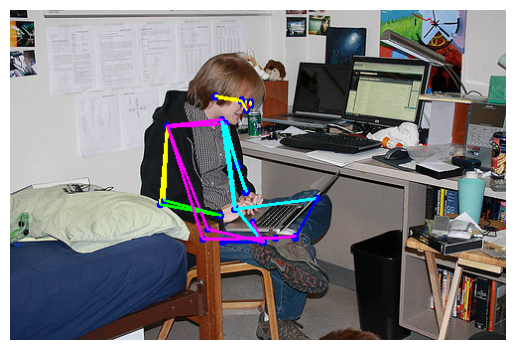

In [39]:
# check validation set
tindex = np.random.randint(0, len(train_dataset))
timage, ttargets = train_dataset[tindex]

model_trained.eval()
if timage is not None:
    with torch.no_grad():
        tannotations = model_trained(timage.unsqueeze(0))
    
    timage_with_keypoints = helpers.draw_keypoints(tannotations, timage)
      
    plt.figure()
    plt.imshow(timage_with_keypoints, cmap='gray')
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


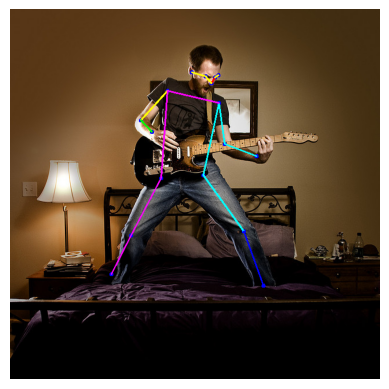

In [35]:
# check validation set
vindex = np.random.randint(0, len(val_dataset))
vimage, vtargets = val_dataset[vindex]

model_trained.eval()
if vimage is not None:
    with torch.no_grad():
        vannotations = model_trained(vimage.unsqueeze(0))
    
    vimage_with_keypoints = helpers.draw_keypoints(vannotations, vimage)
      
    plt.figure()
    plt.imshow(vimage_with_keypoints, cmap='gray')
    plt.axis('off')
    plt.show()

In [36]:
# save images
import cv2
cv2.imwrite(
        './results/keypointrcnn_train_logs_{}/val_sample_{}.png'.format(timestamp, vindex),
        vimage_with_keypoints * 255
        )

True